In [85]:
from utils import *
from similarity_utils import *
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

c:\Users\mpronesti\AppData\Local\anaconda3\envs\bpmn\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


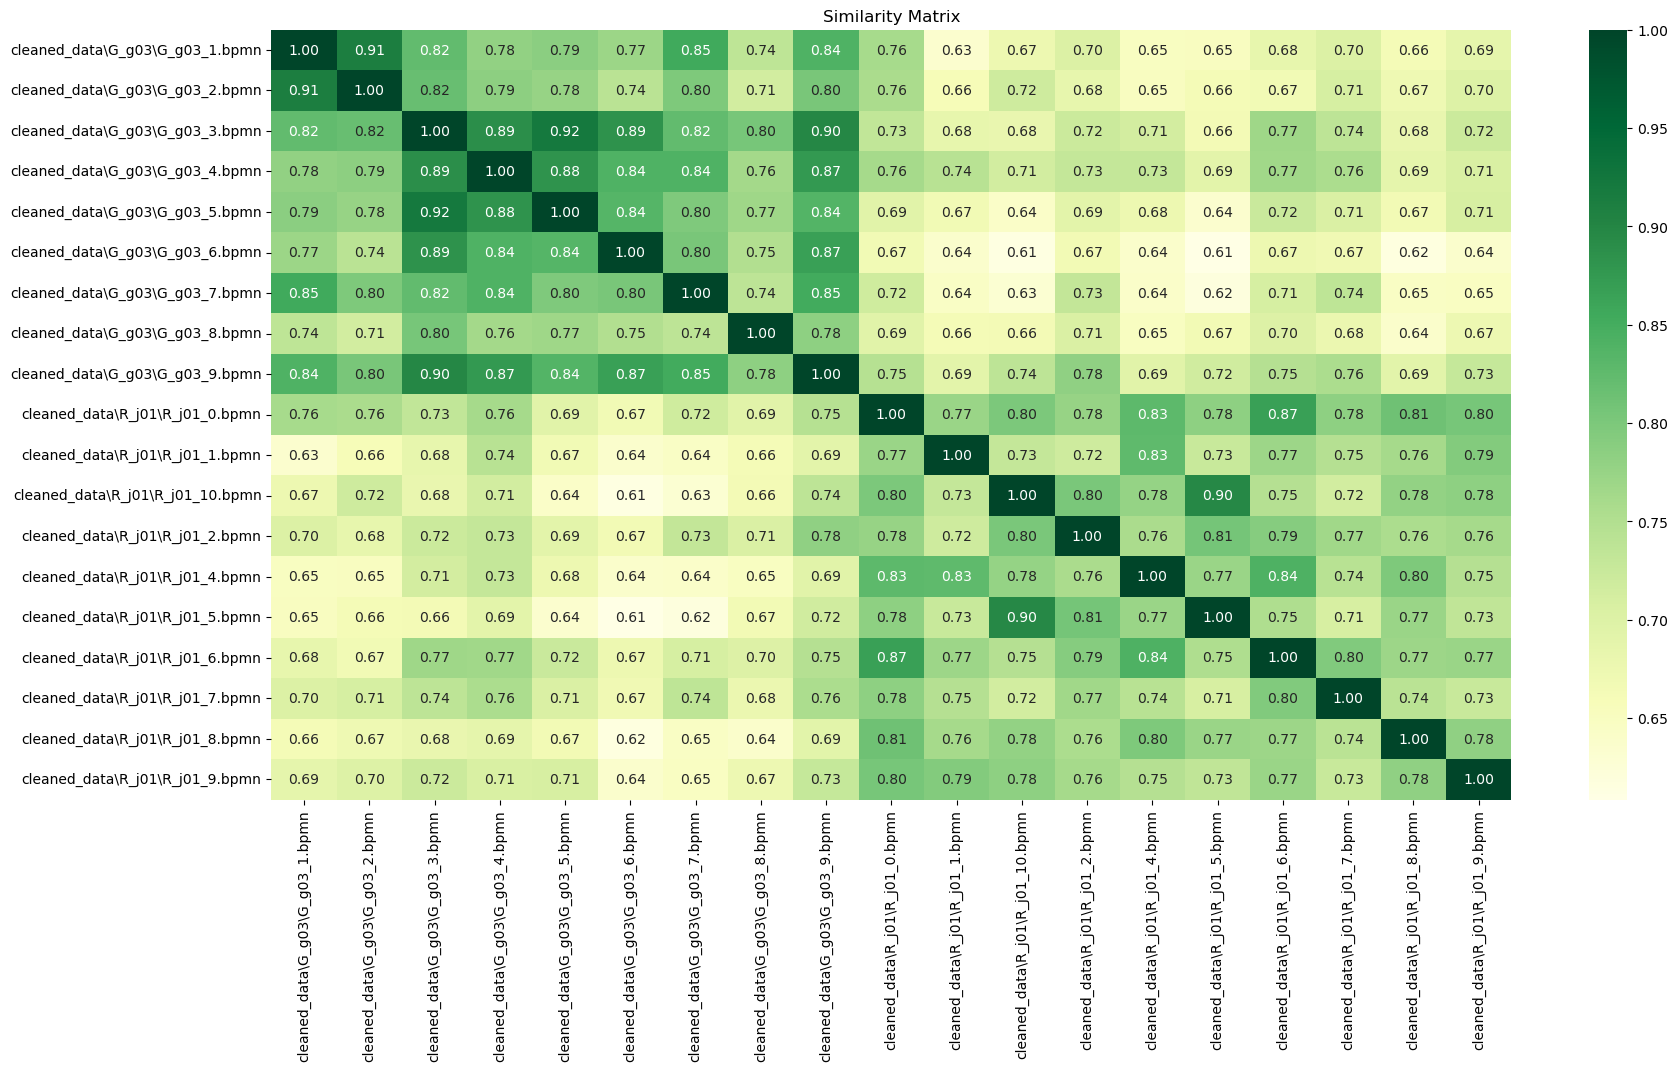

In [86]:
all_files = load_bpmn_files_from_random_folders("cleaned_data", subset_size=2)
#V_k08 = 'cleaned_data\\V_k08'
#G_j01 = 'cleaned_data\\G_j01'

#all_files = load_bpmn_files_from_specific_folder("cleaned_data\E_j03")

files_info = build_process_info_dict(all_files, model)
similarity = get_2ProcessesSimilarity(files_info[all_files[0]], files_info[all_files[1]])

all_files_similarity_matrix = get_AllFilesSimilarityMatrix(files_info)
plot_AllFilesSimilarityMatrix(all_files_similarity_matrix, all_files)